In [2]:
!ls  S2-rocs-1RB.sdf

S2-rocs-0RB.sdf S2-rocs-1RB.sdf S2.pse          S2.sq


In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

rocs = []

for i in (0, 1):
    with Chem.SDMolSupplier(f'S2-rocs-{i}RB.sdf') as sdfh:
        rocs.extend(sdfh)

In [2]:
len(rocs)

1000

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType

prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
prn: ModuleType = pyrosetta.rosetta.numeric
prcc: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_simple: ModuleType = prp.simple_moves
pr_rsele: ModuleType = prc.select.residue_selector
    
# ------------------------------------------------------
    
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)  # logging.WARNING = 30
extra_options = ph.make_option_string(no_optH=False,
                                      ex1=None,
                                      ex2=None,
                                      #mute='all',
                                      ignore_unrecognized_res=True,
                                      load_PDB_components=False,
                                      ignore_waters=True)
pyrosetta.init(extra_options=extra_options)

## ====================================================

# crude filtering via PyRosetta.
# does it affect the masked score (10Å radius of Cys).

from rdkit import Geometry

def mol2pose(mol: Chem.Mol) -> pyrosetta.Pose:
    """
    Given an rdkit mol w/ a conformer make a PyRosetta pose w/ those coordinates
    """
    params = Params.from_mol(mol, name='LIG')
    # params.to_pose() is an ideal pose.
    #params.add_residuetype(pose)
    pose = params.to_pose()
    conf = params.mol.GetConformer()
    for atom in params.mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        pos: Geometry.Point3D = conf.GetAtomPosition(atom.GetIdx())
        xyz = prn.xyzVector_double_t(pos.x, pos.y, pos.z)
        pose.residue(1).set_xyz(name, xyz)
    return pose

def get_radius_score(pose, radius=10) -> float:
    cys_idx = pose.pdb_info().pdb2pose(chain='A', res=147)
    assert pose.residue(cys_idx).name3() == 'CYS'
    neigh_sele = pr_rsele.NeighborhoodResidueSelector(pr_rsele.ResidueIndexSelector(cys_idx),
                                                     radius,
                                                      True
                                                     )
    # scorefxn = pyrosetta.get_fa_scorefxn()
    # # clashes go away...
    # scorefxn.set_weight(pr_scoring.ScoreType.fa_rep, 0)
    # scorefxn(pose) # dummy call or segfault!
    return scorefxn.get_sub_score(pose, neigh_sele.apply(pose))



from rdkit_to_params import Params


def is_good(hit, apo):
    """
    
    """
    try:
        holo = apo.clone()
        lig_pose = mol2pose(hit)
        holo.append_pose_by_jump(lig_pose, holo.num_jump()+1)
        return get_radius_score(holo) - get_radius_score(apo) < -1
    except Exception as error:
        if 'CONN1' not in str(error):
            print(error.__class__.__name__, error)
        return False

/Users/user/.conda/envs/py310/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.m1 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [9]:
from tqdm.notebook import tqdm

with open('template2.pdb') as fh:
    pdbblock = fh.read()
apo = pyrosetta.Pose()
prc.import_pose.pose_from_pdbstring(apo, pdbblock)
scorefxn = pyrosetta.get_fa_scorefxn()
# unaltered:
print(pr_scoring.ScoreType.fa_rep, scorefxn.get_weight(pr_scoring.ScoreType.fa_rep))

apo_score = scorefxn(apo)

good_rocs = []
schmeh_rocs = []
bombed_rocs = []

for i, mol in enumerate(rocs):
    mol.SetProp('_Name', mol.GetProp('id'))
    holo = apo.clone()
    try:
        lig_pose = mol2pose(mol)
        holo.append_pose_by_jump(lig_pose, holo.num_jump()+1)
        score = scorefxn(holo)
        mol.SetDoubleProp('Score', score - apo_score)
        if score - apo_score < 0: # scorefxn(lig_pose) is zero... ish...
            good_rocs.append(mol)
        else:
            schmeh_rocs.append(mol)
    except Exception as error:
        mol.SetProp('issue', f'{error.__class__.__name__}: {error}')
        bombed_rocs.append(mol)

ScoreType.fa_rep 0.55



ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512


In [10]:
len(good_rocs), len(schmeh_rocs), len(bombed_rocs)

(23, 972, 5)

In [13]:
from datetime import date
from typing import Optional

def generate_header(method: str,
                    ref_url: Optional[str]= 'https://www.example.com',
                    submitter_name: Optional[str]= 'unknown',
                    submitter_email: Optional[str] = 'a@b.c',
                    submitter_institution: Optional[str] = 'Nowehere',
                    generation_date: Optional[str] = str(date.today()),
                    smiles: Optional[str] = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
                    extras: Optional[dict] = None) -> Chem.Mol:
    """
    Generate a header Chem.Mol for a SDF file in the ver_1.2 style.
    cf. https://discuss.postera.ai/t/providing-computed-poses-for-others-to-look-at/1155/6

    :param method: **Unique** and compulsory. Note that it will be bleached.
    :param ref_url:
    :param submitter_name:
    :param submitter_email:
    :param submitter_institution:
    :param generation_date:
    :param smiles:
    :param extras:  A dictionary of extra properties to add to the header.
                    These will be present in all the molecules in the SDF for sortable tables!
    :return: Chem.Mol
    """
    bannermol = Chem.MolFromSmiles(smiles)
    bannermol.SetProp('_Name', 'ver_1.2')
    AllChem.EmbedMolecule(bannermol)
    for k, v in {'ref_url': ref_url,
                 'submitter_name': submitter_name,
                 'submitter_email': submitter_email,
                    'submitter_institution': submitter_institution,
                 'generation_date': generation_date,
                 'method': method,
                 }.items():
        bannermol.SetProp(k, v)
    for k, v in extras.items():
        bannermol.SetProp(k, str(v))
    return bannermol

In [14]:
header = generate_header(method='S2-ROCS',
                    ref_url= 'https://github.com/matteoferla/Fragment-hit-follow-up-chemistry',
                    submitter_name= 'Matteo Ferla',
                    submitter_email= 'matteo.ferla@stats.ox.ac.uk',
                    submitter_institution='Oxford',
                    extras={'Score': 'Gibbs Free energy'})

[15:51:51] Molecule does not have explicit Hs. Consider calling AddHs()


In [22]:
with Chem.SDWriter('S2-ROCS.sdf') as sdf:
    sdf.write(header)
    for mol in sorted(good_rocs, key=lambda mol: mol.GetDoubleProp('Score')):
        mol.SetProp('ref_mols', 'x0846_0B')
        mol.SetProp('ref_pdb', 'x0846_0B')
        mol.SetProp('_Name', mol.GetProp('id'))
        mol.SetProp('original SMILES', Chem.MolToSmiles(AllChem.RemoveHs(mol)))
        sdf.write(mol)

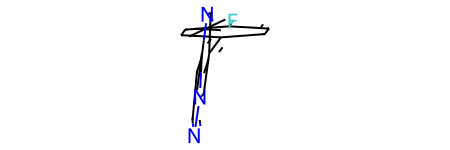

In [20]:
good_rocs[0]